In [38]:
import numpy as np
import pandas as pd

import os
import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18, resnet50
import torch.nn as nn
import torch.nn.functional as F

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers, distances
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from pytorch_metric_learning.utils.inference import CustomKNN
import faiss


from sklearn.model_selection import train_test_split

from online_triplet_loss.losses import *


from tqdm.notebook import tqdm

from PIL import Image
import random



from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import logging

warnings.filterwarnings("ignore")

### Prepare dataframe

In [39]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

df_test = pd.read_csv("Stanford_Online_Products/Ebay_test.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [40]:
df_train, df_valid = train_test_split(df_train, test_size=0.15, random_state=42)

In [41]:
print(f"Length of train {len(df_train)}")
print(f"Length of validation {len(df_valid)}")
print(f"Length of test {len(df_test)}")

Length of train 50618
Length of validation 8933
Length of test 60502


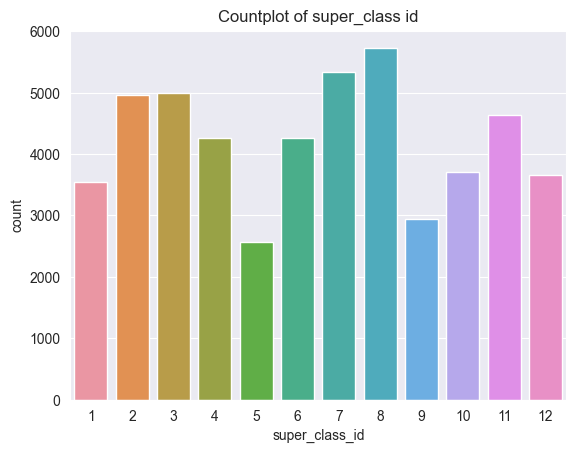

In [42]:
plt.title("Countplot of super_class id")
sns.countplot(data=df_train, x='super_class_id')
plt.show()

In [43]:
PATH = "Stanford_Online_Products"

In [44]:
class ProductDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.data_csv = df
        self.transform = transform
        self.path = path
        self.images = df["path"].values
        self.labels = df["class_id"].values
        self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        image_name = self.images[item]
        image_path = self.path + "/" + image_name
        ###### Anchor Image #######
        img = Image.open(image_path).convert("RGB")
        label = self.labels[item]


        if self.transform != None:
            img = self.transform(img)


        return img, label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [45]:
trainDS = ProductDataset(df=df_train, path=PATH, transform=train_transform)

testDS = ProductDataset(df=df_test, path=PATH, transform=val_transform)

validDS = ProductDataset(df=df_valid, path=PATH, transform=val_transform)

In [46]:
BATCH_SIZE = 128

In [47]:
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)

validLoader = DataLoader(validDS, batch_size=BATCH_SIZE, shuffle=False)
testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
images, labels = next(iter(trainLoader))

In [49]:
images[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


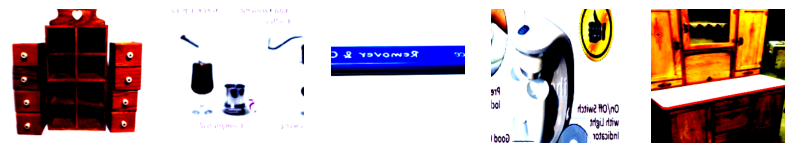

In [50]:
plt.figure(figsize=(10, 50))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
plt.show()

In [51]:
EMBED_DIMS = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
EPOCHS = 20

In [52]:
class ResNet_Triplet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet50(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters, EMBED_DIMS))

    def forward(self,x):
        x = self.Feature_Extractor(x)
        x = F.normalize(x, p=2, dim=1)

        return x

In [53]:
model = ResNet_Triplet()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [54]:
# Set the loss function
# criterion = losses.TripletMarginLoss(margin=0.1)
#distance = distances.LpDistance(p=2, normalize_embeddings=False, power=1)

# loss_func = losses.MarginLoss(margin=0.2,
#                 nu=0,
#                 beta=1.2,
#                 triplets_per_anchor="all",
#                 learn_beta=True,
#                 num_classes=None)

loss_func = losses.TripletMarginLoss(margin=0.2)

#loss_optimizer = torch.optim.SGD(loss_func.parameters(), lr=0.0001, momentum=0.9)

mining_func = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")

# knn_func = CustomKNN(distance=distances.LpDistance())

accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

In [55]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        #loss_optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        #loss_optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {:.4f}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )
        losses.append(loss.detach().numpy())
    return np.mean(losses)

### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester(dataloader_num_workers=16)
#     return tester.get_all_embeddings(dataset, model)

def get_all_embeddings(dataset, model):

    #make dataloader of 1 element in the batch
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_embeddings = torch.zeros(len(dataloader), EMBED_DIMS)
    all_labels = torch.zeros(len(dataloader), 1)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            images, labels = data[0], data[1]
            embeddings = model(images)
            all_embeddings[i]=embeddings
            all_labels[i]=labels

    return all_embeddings, all_labels



### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def eval(train_set, valid_set, model, accuracy_calculator):
    print("compute embeddings of train set")
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    print("compute embeddings of valid set")
    valid_embeddings, valid_labels = get_all_embeddings(valid_set, model)
    train_labels = train_labels.squeeze(1)
    valid_labels = valid_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        valid_embeddings, valid_labels, train_embeddings, train_labels, False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


In [ ]:
train_loss = []
min_loss = 10
for epoch in range(1, EPOCHS + 1):
    epoch_loss = train(model, loss_func, mining_func, DEVICE, trainLoader, optimizer, epoch)
    print(f"Epoch{epoch}/{EPOCHS}: Mean Loss {epoch_loss: .4f}")
    train_loss.append(epoch_loss)
    if epoch_loss < min_loss:
        torch.save(model, "models/model.pts")
        min_loss = epoch_loss
    eval(trainDS, validDS, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.0662, Number of mined triplets = 113


In [ ]:
torch.save(model, "models/model.pts")